# Autoregressive CoRNNs in 1D and 2D

### Task: given previous 3 values, predict next value

- 1D CoRNN uses fully connected weights (torch.linear)
- 2D CoRNN can either use convolution weights (i.e. all pixels share same weights) or pixel-wise convolution (each pixel has separate kernel weights)

In [ ]:
# Download sample data
# !wget https://portal.nersc.gov/project/m4134/ccai_demo.tar
# !tar -xvf ccai_demo.tar
# !rm ccai_demo.tar

In [ ]:
# Skip the below if already installed
# !pip install ruamel.yaml einops timm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os, sys, time
import h5py

# T = 3 = number of input timesteps
# 1 = number of output timesteps
# B = batch size
# C = number of channels
# H = height of image
# W = width of image

# Simple 1D autoregressive CoRNN

In [ ]:
# # this is the standard CoRNN as per the github repo
# class coRNNCell(nn.Module):
#     def __init__(self, n_inp, n_hid, dt, gamma, epsilon):
#         super(coRNNCell, self).__init__()
#         self.dt = dt
#         self.gamma = gamma
#         self.epsilon = epsilon
#         self.i2h = nn.Linear(n_inp + n_hid + n_hid, n_hid)

#     def forward(self,x,hy,hz):
#         hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((x, hz, hy),1)))
#                                    - self.gamma * hy - self.epsilon * hz)
#         hy = hy + self.dt * hz

#         return hy, hz

# class coRNN(nn.Module):
#     def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
#         super(coRNN, self).__init__()
#         self.n_hid = n_hid
#         self.cell = coRNNCell(n_inp,n_hid,dt,gamma,epsilon)
#         self.readout = nn.Linear(n_hid, n_out)

#     def forward(self, x):# (T,B,C)
#         ## initialize hidden states
#         hy = torch.zeros(x.shape[1],self.n_hid, device=x.device, dtype=x.dtype)# (B,C)
#         hz = torch.zeros(x.shape[1],self.n_hid, device=x.device, dtype=x.dtype)
#         for t in range(x.shape[0]):
#             hy, hz = self.cell(x[t],hy,hz)# (B,C)
#         output = self.readout(hy)

#         return output# (B,C')

# # generate some simple 1D time series to learn
# t = np.linspace(0,1,1000)
# x = torch.tensor(np.exp(-t)*(np.sin(5*np.pi*t)+np.sin(7*np.pi*t)), dtype=torch.float32)
# x0,x1_true = torch.stack([x[0:-3],x[1:-2],x[2:-1]], axis=0), x[3:]
# print(x0.shape, x1_true.shape)# (T,B), (B,)

# torch.manual_seed(123)
# model = coRNN(1,64,1,1,1,1)
# print(model)
# print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
# losses = []
# optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
# for i in range(5000):
#     optimizer.zero_grad()

#     x1 = model(x0.unsqueeze(-1)).squeeze()

#     loss = torch.mean((x1-x1_true)**2)
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())

#     # plot results
#     if ((i+1)%1000) == 0 or i==0:
#         x1 = x1.detach()
#         plt.figure(figsize=(10,3))
#         plt.subplot(1,2,1)
#         plt.plot(x0[0], label="x (at t-3)")
#         plt.plot(x1, label="x predicted (at t)")
#         plt.plot(x1_true, label="x true (at t)")
#         plt.legend()
#         plt.subplot(1,2,2)
#         plt.plot(np.array(losses))
#         plt.yscale("log")
#         plt.title(f"Training step: {i+1}")
#         plt.ylabel("Training loss")
#         plt.show()

# 2D autoregressive CoRNN, using 3x3 neighbours only

In [ ]:
# data and model paths
data_path = "./ccai_demo/data/FCN_ERA5_data_v0/out_of_sample"
data_file = os.path.join(data_path, "2018.h5")
model_path = "./ccai_demo/model_weights/FCN_weights_v0/backbone.ckpt"
global_means_path = "./ccai_demo/additional/stats_v0/global_means.npy"
global_stds_path = "./ccai_demo/additional/stats_v0/global_stds.npy"
time_means_path = "./ccai_demo/additional/stats_v0/time_means.npy"
land_sea_mask_path = "./ccai_demo/additional/stats_v0/land_sea_mask.np"

In [ ]:
'''
The ordering of atmospheric variables along the channel dimension is as follows:
'''
variables = ['u10',
             'v10',
             't2m',
             'sp',
             'msl',
             't850',
             'u1000',
             'v1000',
             'z1000',
             'u850',
             'v850',
             'z850',
             'u500',
             'v500',
             'z500',
             't500',
             'z50' ,
             'r500',
             'r850',
             'tcwv']

sample_data = h5py.File(data_file, 'r')['fields'][:,:-1,300:400,800:900]
print('Total data shape:', sample_data.shape)

Total data shape: (40, 20, 100, 100)


In [ ]:
# class PixelwiseConv2d(nn.Module):
#     # TODO: check this code, generated by chatgpt!!

#     def __init__(self, in_channels, out_channels, kernel_size, input_height, input_width, stride=1, padding=0, dilation=1):
#         super(PixelwiseConv2d, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.padding = padding
#         self.dilation = dilation
#         self.input_height = input_height
#         self.input_width = input_width

#         # Calculate the output dimensions
#         self.output_height = (input_height + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
#         self.output_width = (input_width + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

#         # Define a weight tensor for each pixel in the output
#         self.weights = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size, self.output_height, self.output_width))
#         self.bias = nn.Parameter(torch.randn(out_channels, self.output_height, self.output_width))

#     def forward(self, x):
#         batch_size = x.size(0)
#         #print()
#         #print(x.shape)

#         # Unfold the input into sliding local blocks
#         x_unfolded = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, dilation=self.dilation)
#         #print(x_unfolded.shape)

#         # Reshape unfolded input to (batch_size, in_channels, kernel_size, kernel_size, output_height, output_width)
#         x_unfolded = x_unfolded.view(batch_size, self.in_channels, self.kernel_size, self.kernel_size, self.output_height, self.output_width)
#         #print(x_unfolded.shape)
#         #print(self.weights.shape)

#         # Perform element-wise multiplication and sum over in_channels, kernel_size, and kernel_size
#         output = (x_unfolded.unsqueeze(1) * self.weights).sum(dim=(2, 3, 4)) + self.bias
#         #print(output.shape)
#         #print()

#         return output

# # Example usage
# input_height, input_width = 8, 8
# in_channels = 3
# out_channels = 16
# kernel_size = 3
# stride = 1
# padding = 1

# model = PixelwiseConv2d(in_channels, out_channels, kernel_size, input_height, input_width, stride, padding)
# input_tensor = torch.randn(1, in_channels, input_height, input_width)
# output = model(input_tensor)
# print(output.shape)  # Expected shape: (1, out_channels, input_height, input_width)

torch.Size([1, 16, 8, 8])


In [ ]:
from torch import nn
import torch
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# # this modified for 2D images as input
class coRNNCell(nn.Module):
    def __init__(self, n_inp, n_hid, dt, gamma, epsilon):
        super(coRNNCell, self).__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        #self.i2h = PixelwiseConv2d(n_inp + n_hid + n_hid, n_hid, 3, 12, 10, stride=1, padding=1, dilation=1)
        self.i2h = nn.Conv2d(n_inp + n_hid + n_hid, n_hid, 3, stride=1, padding=1, dilation=1,
                            padding_mode="replicate")

    def forward(self,x,hy,hz):
        hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((x, hz, hy),1)))
                                   - self.gamma * hy - self.epsilon * hz)
        hy = hy + self.dt * hz

        return hy, hz

class coRNN(nn.Module):
    def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
        super(coRNN, self).__init__()
        self.n_hid = n_hid
        self.cell = coRNNCell(n_inp,n_hid,dt,gamma,epsilon)
        self.readout = nn.Conv2d(n_hid, n_out, 1)

    def forward(self, x):# (T,B,C,H,W)
        ## initialize hidden states
        hy = torch.zeros(x.shape[1],self.n_hid,x.shape[3],x.shape[4], device=x.device, dtype=x.dtype)# (B,C,H,W)
        hz = torch.zeros(x.shape[1],self.n_hid,x.shape[3],x.shape[4], device=x.device, dtype=x.dtype)
        for t in range(x.shape[0]):
            hy, hz = self.cell(x[t],hy,hz)# (B,C,H,W)
        output = self.readout(hy)
        return output# (B,C',H,W)

Using device: cuda


In [ ]:
# this modified for 2D images as input
class coRNNCell2(nn.Module):
    def __init__(self, n_hid, dt, gamma, epsilon):
        super(coRNNCell2, self).__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        # self.i2h = PixelwiseConv2d(n_hid + n_hid, n_hid, 3, 12, 10, stride=1, padding=1, dilation=1)
        self.i2h = nn.Conv2d(n_hid + n_hid, n_hid, 3, stride=1, padding=1, dilation=1,
                            padding_mode="replicate")

    def forward(self,hy,hz):
        hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((hz, hy),1)))
                                   - self.gamma * hy - self.epsilon * hz)
        hy = hy + self.dt * hz

        return hy, hz

class coRNN2(nn.Module):
    def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
        super(coRNN2, self).__init__()
        self.n_hid = n_hid
        self.readin = nn.Conv2d(3*n_inp, 2*n_hid, 3, stride=1, padding=1, dilation=1,
                                padding_mode="replicate")
        self.cell = coRNNCell2(n_hid,dt,gamma,epsilon)
        self.readout = nn.Conv2d(n_hid, n_out, 1)

    def forward(self, x):# (T,B,C,H,W)
        ## initialize hidden states
        x = x.transpose(0,1).reshape(x.shape[1],x.shape[0]*x.shape[2], x.shape[3], x.shape[4])# (B,TC,H,W)
        h = self.readin(x)# (B,2C,H,W)
        hy, hz = h[:,:self.n_hid], h[:,self.n_hid:]
        for t in range(3):
            hy, hz = self.cell(hy,hz)# (B,C,H,W)
        output = self.readout(hy)
        return output# (B,C',H,W)

In [ ]:
VARIABLE_TO_TEST = 'u10' # CHANGE THIS TO VISUALIZE DIFFERENT VARIABLES
VARIDX = variables.index(VARIABLE_TO_TEST)

In [ ]:
# # # generate some simple 2D time series to learn
# # t = np.linspace(0,1,100)
# # xx,yy = np.meshgrid(np.arange(10),np.arange(12),)
# # x = np.stack([np.sin(xx+np.cos(20*tval)*yy+20*tval)+np.sin(xx+yy+13*tval) for tval in t], axis=0)# (B,H,W)
# # x = torch.tensor(x, dtype=torch.float32)
# # print(x.shape)
# # x0,x1_true = torch.stack([x[0:-3],x[1:-2],x[2:-1]], axis=0), x[3:]# (T,B,H,W), (B,H,W)
# # x0, x1_true = x0.to(device), x1_true.to(device)
# # print(x0.shape, x1_true.shape)

# # Prepare the data
# # (T,B,C,H,W)
# x = torch.tensor(sample_data, dtype=torch.float32).to(device)

# # normalize the data
# mean = x.mean(dim=(0, 2, 3), keepdim=True)
# std = x.std(dim=(0, 2, 3), keepdim=True)
# x = (x - mean) / std

# # train on the t-3, t-2, t-1 timesteps to predict t
# x0, x1_true = torch.stack([x[0:-3], x[1:-2], x[2:-1]], axis=0), x[3:]  # (T,B,C,H,W), (B,C,H,W)
# x0, x1_true = x0.to(device), x1_true.to(device)
# print(x0.shape, x1_true.shape)  # Verify shapes

# # Model and training setup
# torch.manual_seed(123)
# n_inp = x0.shape[2]  # Number of input channels
# n_hid = 64
# # n_out = x1_true.shape[2]  # Number of output channels
# dt = 1.0
# gamma = 1.0
# epsilon = 1.0
# # model = coRNN(n_inp, n_hid, n_out, dt, gamma, epsilon)
# # model = coRNN(n_inp, n_hid, 1, dt, gamma, epsilon).to(device)
# model = coRNN2(n_inp, n_hid, 1, dt, gamma, epsilon).to(device)
# print(model)
# print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# losses = []
# optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
# for i in tqdm(range(5000), desc="Training Progress"):
#     optimizer.zero_grad()

#     x1 = model(x0).squeeze()

#     # Just outputting temp so thats all we want to compare against
#     x1_true_var = x1_true[:,VARIDX,:,:].squeeze()
#     loss = torch.mean((x1-x1_true_var)**2)

#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())

#     # plot results
#     if ((i+1)%500) == 0 or i==0:
#         # x0_cpu = x0.detach().cpu()
#         x1_cpu = x1.detach().cpu()
#         x1_true_cpu = x1_true_var.detach().cpu()
#         plt.figure(figsize=(10,4))
#         for ip,i_ in enumerate(np.arange(0,40,10)):
#             plt.subplot(2,10,ip+1)
#             plt.imshow(x1_cpu[i_])
#             plt.title(f"x predicted\nt={i_}",fontsize="small")
#             plt.axis("off")
#             plt.subplot(2,10,10+ip+1)
#             plt.imshow(x1_true_cpu[i_])
#             plt.title(f"x true\nt={i_}",fontsize="small")
#             plt.axis("off")
#         plt.show()

#         plt.figure(figsize=(10,3))
#         plt.subplot(1,2,1)
#         # plt.plot(x0_cpu[0,:,0,0], label="x[0,0] (at t-3)")
#         plt.plot(x1_cpu[:,0,0], label="x[0,0] predicted (at t)")
#         plt.plot(x1_true_cpu[:,0,0], label="x[0,0] true (at t)")
#         plt.legend()
#         plt.subplot(1,2,2)
#         plt.plot(np.array(losses))
#         plt.yscale("log")
#         plt.title(f"Training step: {i+1}")
#         plt.ylabel("Training loss")
#         plt.show()

torch.Size([3, 37, 20, 100, 100]) torch.Size([37, 20, 100, 100])
coRNN2(
  (readin): Conv2d(60, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (cell): coRNNCell2(
    (i2h): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  )
  (readout): Conv2d(64, 20, kernel_size=(1, 1), stride=(1, 1))
)
Total parameters: 144340



Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

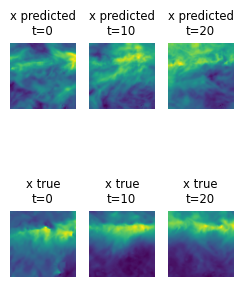

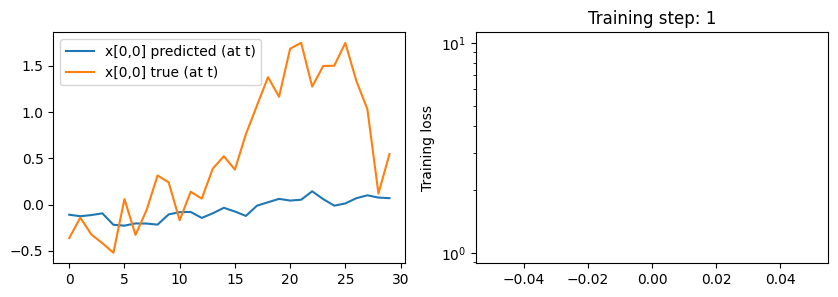

Training Progress:  10%|▉         | 499/5000 [01:06<09:47,  7.66it/s]

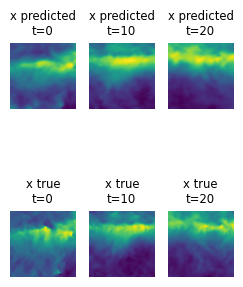

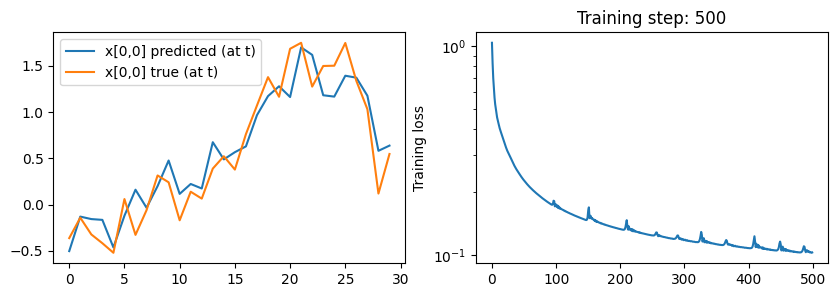

Training Progress:  20%|█▉        | 999/5000 [02:12<08:43,  7.64it/s]

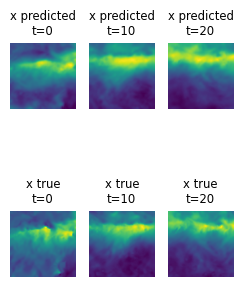

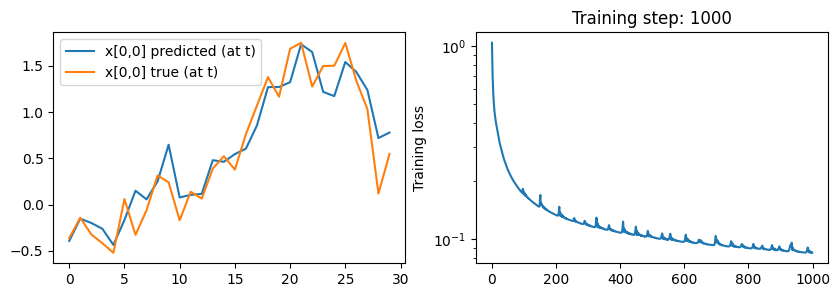

Training Progress:  30%|██▉       | 1499/5000 [03:18<07:39,  7.62it/s]

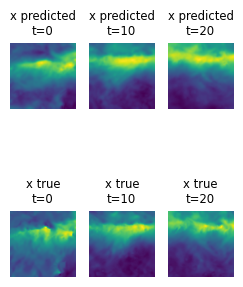

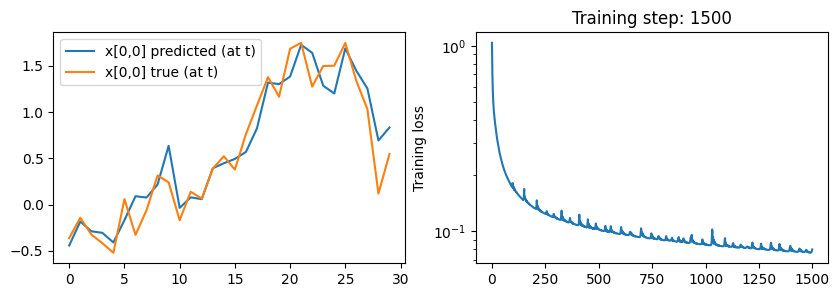

Training Progress:  40%|███▉      | 1999/5000 [04:25<06:33,  7.62it/s]

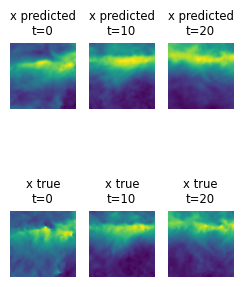

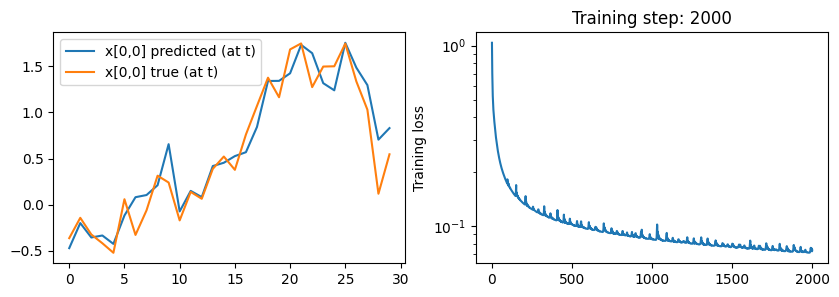

Training Progress:  50%|████▉     | 2499/5000 [05:31<05:28,  7.62it/s]

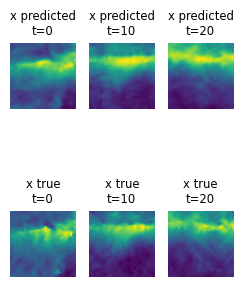

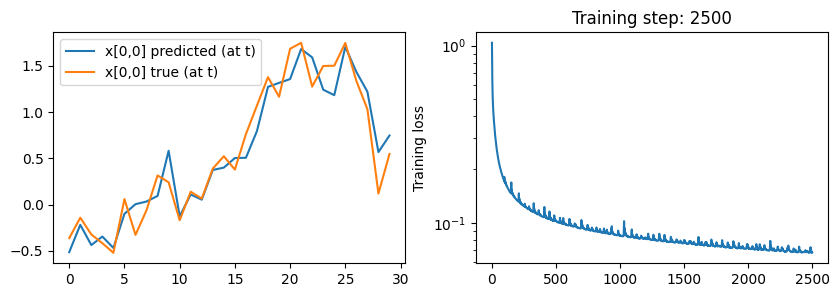

Training Progress:  60%|█████▉    | 2999/5000 [06:37<04:21,  7.65it/s]

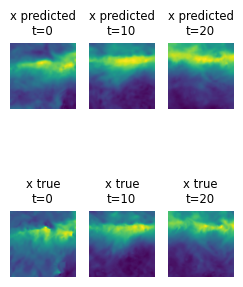

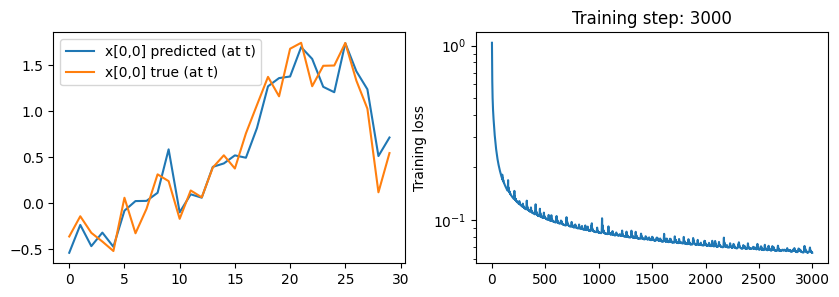

Training Progress:  70%|██████▉   | 3499/5000 [07:43<03:16,  7.66it/s]

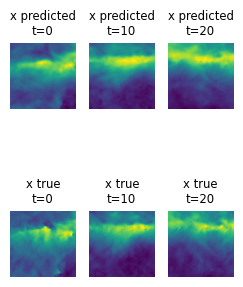

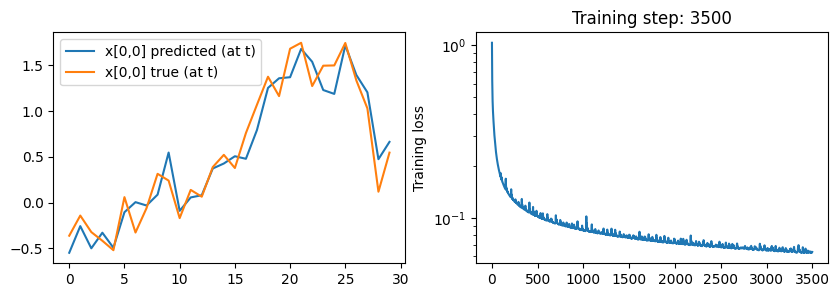

Training Progress:  80%|███████▉  | 3999/5000 [08:49<02:11,  7.62it/s]

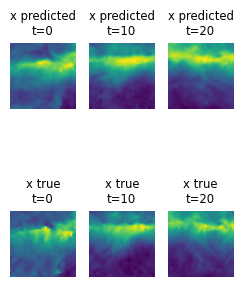

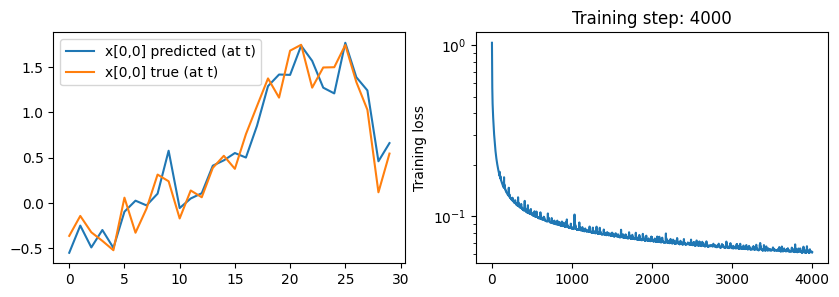

Training Progress:  90%|████████▉ | 4499/5000 [09:56<01:05,  7.65it/s]

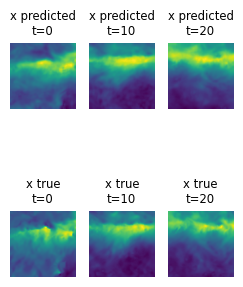

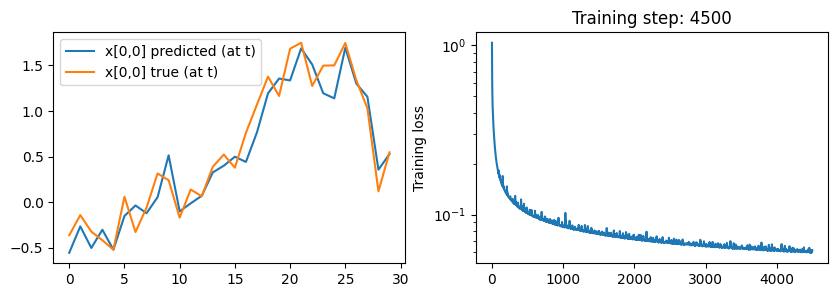

Training Progress: 100%|█████████▉| 4999/5000 [11:02<00:00,  7.62it/s]

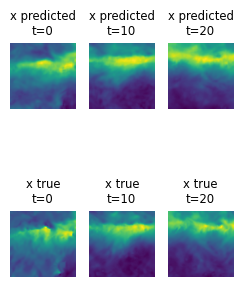

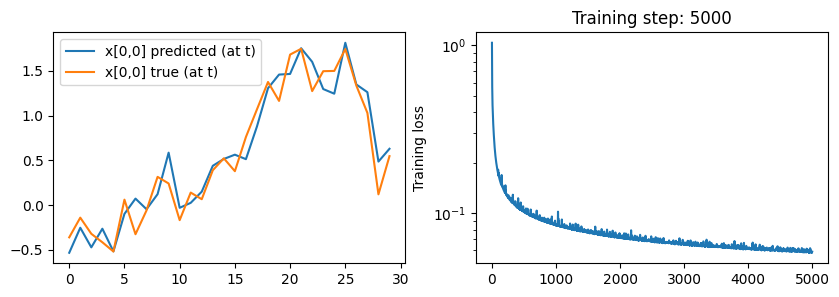

Training Progress: 100%|██████████| 5000/5000 [11:03<00:00,  7.54it/s]


In [ ]:
# Prepare the data
# (T,B,C,H,W)
x = torch.tensor(sample_data, dtype=torch.float32).to(device)

# normalize the data
mean = x.mean(dim=(0, 2, 3), keepdim=True)
std = x.std(dim=(0, 2, 3), keepdim=True)
x = (x - mean) / std

# train on the t-3, t-2, t-1 timesteps to predict t
x0, x1_true = torch.stack([x[0:-3], x[1:-2], x[2:-1]], axis=0), x[3:]  # (T,B,C,H,W), (B,C,H,W)
x0, x1_true = x0.to(device), x1_true.to(device)
print(x0.shape, x1_true.shape)  # Verify shapes

# Model and training setup
torch.manual_seed(123)
n_inp = x0.shape[2]  # Number of input channels
n_hid = 64
n_out = x1_true.shape[1]  # Number of output channels
dt = 1.0
gamma = 1.0
epsilon = 1.0
# model = coRNN(n_inp, n_hid, n_out, dt, gamma, epsilon)
# model = coRNN(n_inp, n_hid, 1, dt, gamma, epsilon).to(device)
model = coRNN2(n_inp, n_hid, n_out, dt, gamma, epsilon).to(device)
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

TRAIN_SIZE = 30
DATA_LENGTH = 40
x0_train, x1_true_train = x0[:, :TRAIN_SIZE, :, :, :], x1_true[:TRAIN_SIZE, :, :, :]

print()
losses = []
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
for i in tqdm(range(5000), desc="Training Progress"):
    optimizer.zero_grad()

    x1 = model(x0_train).squeeze()

    # Just outputting temp so thats all we want to compare against
    x1_true_var = x1_true_train

    # print(x1_true_var.shape, x1.shape)
    loss = torch.mean((x1-x1_true_var)**2)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # plot results
    if ((i+1)%500) == 0 or i==0:
        # x0_cpu = x0.detach().cpu()
        x1_cpu = x1[:,VARIDX,:,:].detach().cpu()
        x1_true_cpu = x1_true_var[:,VARIDX,:,:].detach().cpu()
        plt.figure(figsize=(10,4))
        for ip,i_ in enumerate(np.arange(0,TRAIN_SIZE,10)):
            plt.subplot(2,10,ip+1)
            plt.imshow(x1_cpu[i_])
            plt.title(f"x predicted\nt={i_}",fontsize="small")
            plt.axis("off")
            plt.subplot(2,10,10+ip+1)
            plt.imshow(x1_true_cpu[i_])
            plt.title(f"x true\nt={i_}",fontsize="small")
            plt.axis("off")
        plt.show()

        plt.figure(figsize=(10,3))
        plt.subplot(1,2,1)
        # plt.plot(x0_cpu[0,:,0,0], label="x[0,0] (at t-3)")
        plt.plot(x1_cpu[:,0,0], label="x[0,0] predicted (at t)")
        plt.plot(x1_true_cpu[:,0,0], label="x[0,0] true (at t)")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(np.array(losses))
        plt.yscale("log")
        plt.title(f"Training step: {i+1}")
        plt.ylabel("Training loss")
        plt.show()

In [ ]:
VARIABLE_TO_TEST = 'u10' # CHANGE THIS TO VISUALIZE DIFFERENT VARIABLES
VARIDX = variables.index(VARIABLE_TO_TEST)

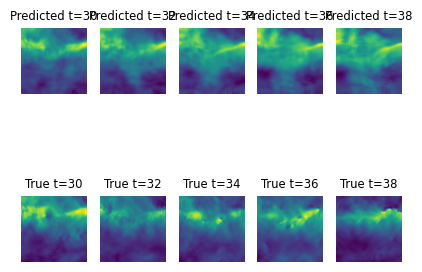

torch.Size([10, 20, 100, 100]) torch.Size([10, 20, 100, 100])


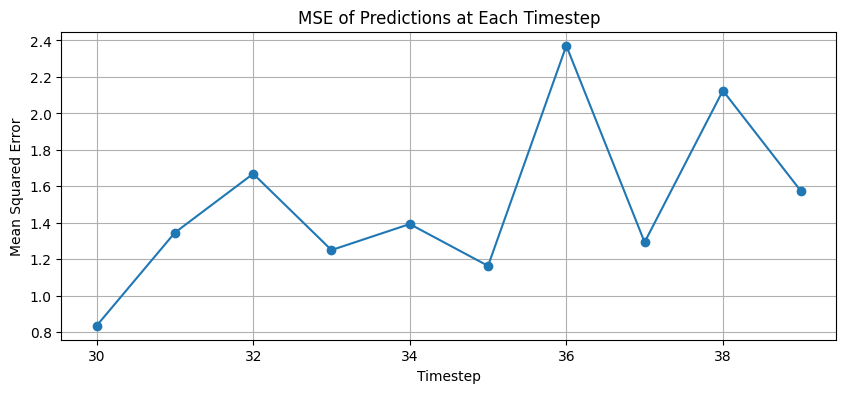

In [ ]:
# Evaluation
# Predict from sample 27 to 30 and then predict 30, 31,..., 40 using previous predictions
predictions = []
current_input = x0[:, TRAIN_SIZE, :, :, :].unsqueeze(1).to(device)  # Initial input for evaluation

for t in range(TRAIN_SIZE, DATA_LENGTH):
    with torch.no_grad():
        # print(current_input.shape)
        pred = model(current_input).squeeze()
        predictions.append(pred)

        # Prepare the next input by adding the latest prediction and removing the oldest input
        # print(pred.shape)
        # print(pred.unsqueeze(0).unsqueeze(1).shape)
        next_input = torch.cat((current_input[1:, :, :, :, :], pred.unsqueeze(0).unsqueeze(1)), dim=0)
        current_input = next_input

# Plot evaluation results
predictions = torch.stack(predictions, dim=0)
x_true = x[TRAIN_SIZE:DATA_LENGTH, :, :, :]

plt.figure(figsize=(10, 4))
for ip, i_ in enumerate(np.arange(0, 10, 2)):
    plt.subplot(2, 10, ip + 1)
    plt.imshow(predictions[i_][VARIDX,:,:].cpu().numpy(), cmap='viridis')
    plt.title(f"Predicted t={30+i_}", fontsize="small")
    plt.axis("off")
    plt.subplot(2, 10, 10 + ip + 1)
    plt.imshow(x_true[i_][VARIDX,:,:].cpu().numpy(), cmap='viridis')
    plt.title(f"True t={30+i_}", fontsize="small")
    plt.axis("off")
plt.show()


print(predictions.shape, x_true.shape)
# Calculate MSE for each timestep
mse_per_timestep = torch.mean((predictions - x_true) ** 2, dim=[1, 2, 3])

# Convert to numpy for plotting
mse_per_timestep = mse_per_timestep.cpu().numpy()

# Plot the MSE for each timestep
plt.figure(figsize=(10, 4))
plt.plot(np.arange(TRAIN_SIZE, DATA_LENGTH), mse_per_timestep, marker='o')
plt.xlabel('Timestep')
plt.ylabel('Mean Squared Error')
plt.title('MSE of Predictions at Each Timestep')
plt.grid(True)
plt.show()